In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE


/home/nwertheim/miniconda3/bin/python


In [8]:
train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_test.npy")
test_data = np.load(test_dir, allow_pickle=True)

def count_labels(data, dataset_name=""):
    preterm_count = sum(1 for item in data if item['preterm'] == 1)
    term_count = sum(1 for item in data if item['preterm'] == 0)
    total = preterm_count + term_count
    print(f"{dataset_name} - Preterm (1): {preterm_count} | Term (0): {term_count}")
    print('Distribution term :', term_count / total)
    print('Distribution preterm :', preterm_count / total)

count_labels(train_data, "Train")
count_labels(test_data, "Test")


Train - Preterm (1): 75 | Term (0): 49
Distribution term : 0.3951612903225806
Distribution preterm : 0.6048387096774194
Test - Preterm (1): 20 | Term (0): 12
Distribution term : 0.375
Distribution preterm : 0.625


In [9]:
# import matplotlib.pyplot as plt
# from collections import Counter
# import numpy as np

# # Count labels in both datasets
# train_counts = Counter([instance['preterm'] for instance in train_data])
# test_counts = Counter([instance['preterm'] for instance in test_data])

# # Values for plotting
# splits = ['Train', 'Test']
# term_counts = [train_counts[0], test_counts[0]]
# preterm_counts = [train_counts[1], test_counts[1]]

# x = np.arange(len(splits))  # [0, 1]
# bar_width = 0.35

# # Plot side-by-side bars
# plt.figure(figsize=(8, 6))
# plt.bar(x - bar_width/2, term_counts, width=bar_width, label='Term (0)', color='skyblue')
# plt.bar(x + bar_width/2, preterm_counts, width=bar_width, label='Preterm (1)', color='salmon')

# # Formatting
# plt.xticks(x, splits)
# plt.ylabel('Number of Instances')
# plt.title('Class Distribution for Train and Test Set')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


In [10]:
print(train_data[0])

{'record_name': np.str_('Hopper-2022_08_24_06_55_46-0000010181-0001'), 'signal': array([[ -8.77326634],
       [-16.30170858],
       [-12.15312614],
       ...,
       [  1.94513686],
       [  0.52803341],
       [  2.90890496]]), 'fs': 20, 'preterm': 1}


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNHead(nn.Module):
    def __init__(self, input_channels):
        super(CNNHead, self).__init__()
        
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64, 2)  # Assuming binary classification (output_dim = 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)


class ClassifierWithCNNHead(nn.Module):
    def __init__(self, encoder: nn.Sequential):
        super(ClassifierWithCNNHead, self).__init__()
        self.encoder = encoder  # Pre-trained encoder (frozen externally)
        
        # Determine the encoder output shape
        self.encoder_output_shape = self._get_encoder_output_shape()
        encoder_channels, encoder_length = self.encoder_output_shape

        # CNN classifier head expects (batch, channels, length)
        self.cnn_head = CNNHead(input_channels=encoder_channels)

    def _get_encoder_output_shape(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 12000)
            output = self.encoder(dummy_input)
            return output.shape[1], output.shape[2]  # (channels, length)

    def forward(self, x):
        encoded_features = self.encoder(x)  # (B, C, L)
        output = self.cnn_head(encoded_features)  # (B, 2)
        return output


Train label distribution:
  Term (0): 319
  Preterm (1): 752

Test label distribution:
  Term (0): 306
  Preterm (1): 593
Epoch [1/10], Train Loss: 0.5857, Test Loss: 0.6756
Epoch [2/10], Train Loss: 0.5647, Test Loss: 0.7225
Epoch [3/10], Train Loss: 0.5644, Test Loss: 0.6968
Epoch [4/10], Train Loss: 0.5507, Test Loss: 0.7579
Epoch [5/10], Train Loss: 0.5538, Test Loss: 0.6752
Epoch [6/10], Train Loss: 0.5547, Test Loss: 0.7284
Epoch [7/10], Train Loss: 0.5490, Test Loss: 0.8135
Epoch [8/10], Train Loss: 0.5491, Test Loss: 0.7103
Epoch [9/10], Train Loss: 0.5449, Test Loss: 0.6704
Epoch [10/10], Train Loss: 0.5408, Test Loss: 0.7844


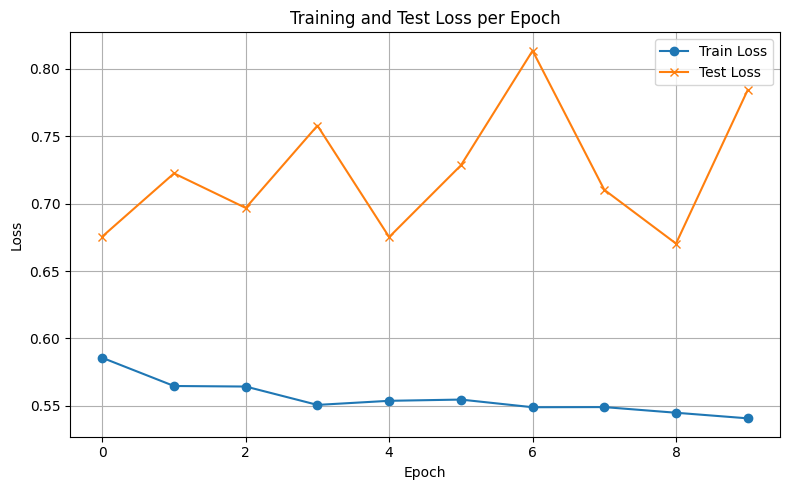

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter


# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_encoder_cpu_final.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=128, num_blocks=5, kernel_size=9)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

# Define the classifier model
model = ClassifierWithCNNHead(encoder)

# Move the model to the device
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Apply class weights here
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_input, batch_labels in train_loader:
        batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
        batch_input = batch_input.unsqueeze(1)

        optimizer.zero_grad()
        output = model(batch_input)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_input, batch_labels in test_loader:
            batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
            batch_input = batch_input.unsqueeze(1)
            output = model(batch_input)
            loss = criterion(output, batch_labels)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot train vs test loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0     0.4423    0.0752    0.1285       306
           1     0.6659    0.9511    0.7833       593

    accuracy                         0.6529       899
   macro avg     0.5541    0.5131    0.4559       899
weighted avg     0.5898    0.6529    0.5604       899

Accuracy:  0.6529
Precision: 0.6659
Recall:    0.9511
F1 Score:  0.7833
AUC:       0.5369
AP Score:  0.6589


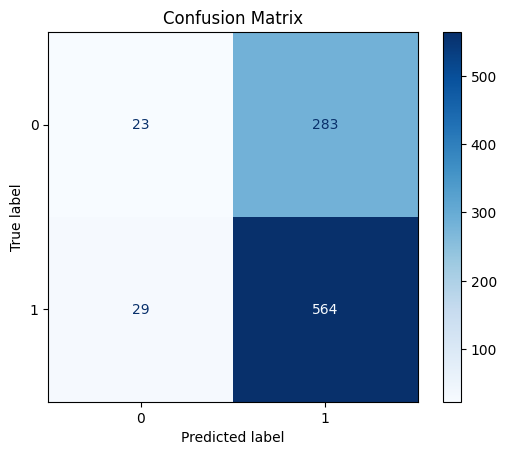

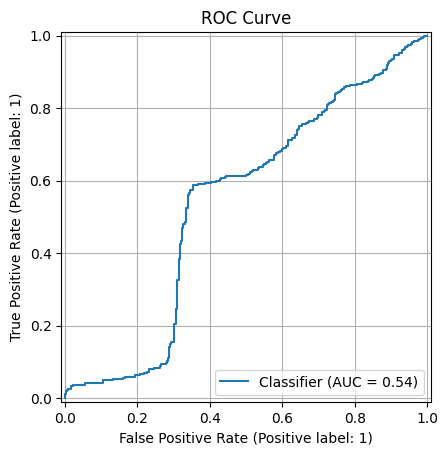

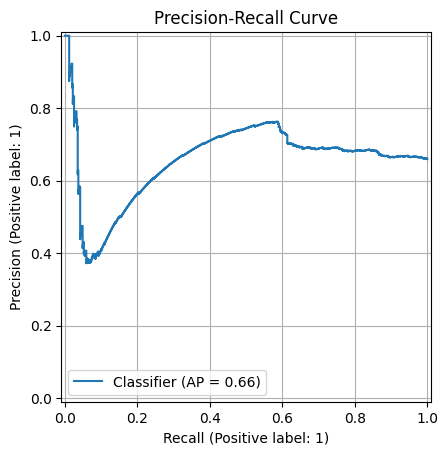

In [13]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import numpy as np

# Evaluation
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for batch_input, batch_labels in test_loader:
        batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
        batch_input = batch_input.unsqueeze(1)
        output = model(batch_input)

        probs = torch.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        all_targets.extend(batch_labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_targets)
y_pred = np.array(all_preds)
y_score = np.array(all_probs)

# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
print(f"AUC:       {roc_auc_score(y_true, y_score):.4f}")
print(f"AP Score:  {average_precision_score(y_true, y_score):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
